# Внутренняя кухня обучения

In [1]:
import torch
import matplotlib.pyplot as plt

## Обучение — это просто оценка параметров

На **рис. 5.2** показана общая картина того, что мы реализуем к концу данной главы. При заданных исходных данных и соответствующих желаемых выходных сигналах (контрольные данные), а также при начальных значениях весовых коэффициентов модель получает входные данные (прямой проход), после чего вычисляется мера ошибки через сравнение полученных выходных сигналов с контрольными данными. Для оптимизации параметров модели — ее весовых коэффициентов (весов) — вычисляется степень изменения ошибки при единичном изменении весов (то есть градиент ошибки относительно параметров) с помощью цепного правила вычисления производной сложной функции (обратный проход). После чего значения весовых коэффициентов обновляются так, чтобы можно было уменьшить ошибку. Процедура повторяется до тех пор, пока оценка ошибки на еще не встречавшихся моделях данных не окажется ниже приемлемого уровня. Если сказанное пока не вполне понятно — у нас есть целая глава, чтобы пояснить, что к чему. К концу главы все части головоломки окажутся на своих местах, а этот абзац станет совершенно понятен.

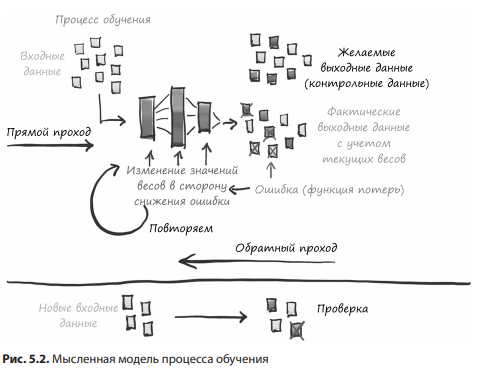

Теперь мы возьмем задачу с зашумленным набором данных, создадим модель и реализуем для нее алгоритм обучения. Сначала мы будем делать все вручную, но к концу главы переложим всю тяжелую работу на PyTorch. К концу главы мы охватим многие важнейшие понятия, связанные с обучением глубоких нейронных сетей, хотя наш иллюстрирующий пример очень прост, а модель не является (пока) нейронной сетью.

## "Жаркая" задача

## Сбор данных

Начнем с того, что запишем температуру в старых добрых градусах по цельсию и показания нашего нового термометра. Через несколько недель получаем следующий набор данных:

In [2]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Здесь значения **t_c** - температура в градусах по Цельсию, а значения **t_u** - в неизвестных единицах измерения. В обоих измерениях возможен шумь который появляется, как при работе самих приборов, так и при снятии самих показаний. Для удобства мы уже поместили данные в тензоры.

***
## Визуализация данных

Text(0.5, 0, 'Измерение')

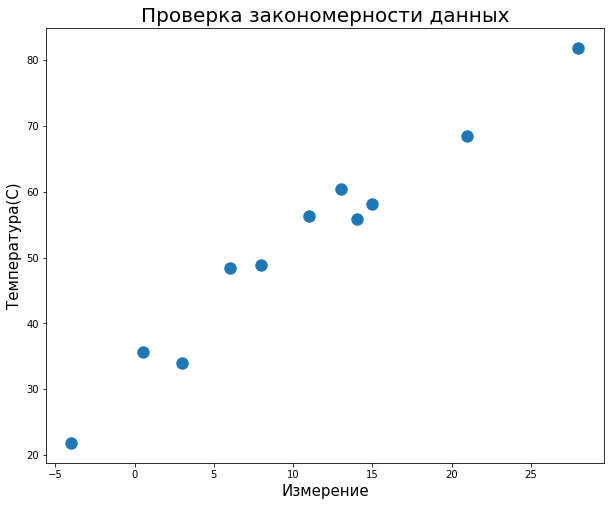

In [3]:
plt.figure(figsize=(10,8))

plt.scatter(t_c, t_u, s=130)
plt.title('Проверка закономерности данных', fontsize=20)
plt.ylabel('Температура(С)', fontsize=15)
plt.xlabel('Измерение', fontsize=15)

Возможно, наши неизвестные данные описываются линейной моделью.

## Выбираем линейную модель для первой попытки

Поскольку дополнительной информации у нас нет, предположим, что взаимосвязь двух наборов измерений описывается простейшей возможной моделью. Итак, допустим, что эти наборы связанны линейно, то есть для получения температуры в градусах по Цельсию достаточно умножить t_u на коэфициент и прибавить некоторое смещение (с точностью до ошибки, которую мы не учитываем)

**t_c = w * t_u + b**

***
## Наша цель — минимизация потерь


Функция потерь (loss function) (она же функция стоимости (cost function)) — это функция, возвращающая одно числовое значение, которое процесс обучения должен минимизировать. Вычисление функции потерь обычно означает вычисление разности между желаемыми выходными сигналами для каких-то примеров данных и выходными сигналами, фактически сгенерированными моделью при подаче на ее вход этих примеров. В нашем случае это означает разность между предсказанными нашей моделью температурами **t_p** и фактически измеренными значениями: **t_p — t_c**.

Необходимо гарантировать, что функция потерь возвращает положительное значение и когда **t_p** больше, и когда меньше, чем истинное t_c, поскольку наша цель состоит в том, чтобы значение **t_p** было какможно ближе к значению **t_c**. Существует несколько вариантов, простейшие из которых $|t_p — t_c|$ и $(t_p — t_c)^2$. В зависимости от выбранного математического выражения можно акцентировать внимание на определенных видах ошибки или, наоборот, сокращать их роль. В теории функция потерь представляет собой способ расстановки приоритетов исправления ошибок, так что обновления параметров приводят к корректировке выходных сигналов для примеров данных с большимвесом, а не к изменениямвыходных сигналов других примеров данных сменьшимзначением функции потерь.


Минимум обеих приведенных функций потерь отчетливо достигается в нуле, они обе монотонно растут по мере удаления предсказанного значения от истинного в любом направлении. Поскольку крутизна графика также монотонно растет по мере удаления от минимума, обе функции — выпуклые (convex). Поскольку наша модель линейна, функция потерь (как функция w и b) также будет выпуклой.


Случаи, когда функция потерь является выпуклой функцией параметров модели, обычно очень удобны, поскольку позволяют очень эффективно находить минимум с помощью специализированных алгоритмов. 
Однако в этой главемы воспользуемся более универсальными, хотя и не обладающими столь широкими возможностями,методами. 
А все потому, что для интересующих нас в конечном итоге нейронныхсетей функция потерь не является выпуклой функцией входных сигналов.

Как видно из рис. 5.4, в случае наших двух функций потерь квадраты разностей ведут себя лучше возле минимума: производная функции потерь на основе квадрата ошибки по **t_p** равна нулю, когда **t_p** равняется **t_c**. У модуля же, с другой
стороны, производная не определена как раз там, где нам нужна сходимость.
На практике это не такая большая проблема, как может показаться, но мы пока
что остановим свой взгляд на функции квадрата разности.

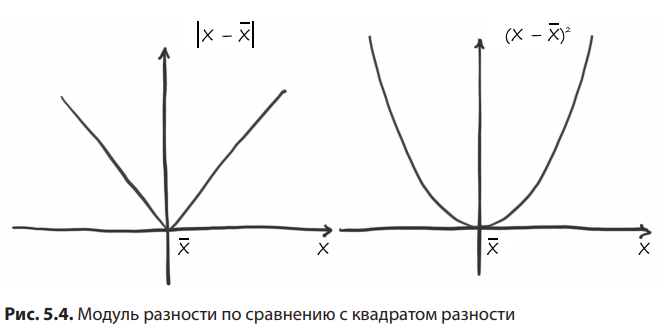


Стоит отметить, что квадрат разности штрафует далекие от правильных результаты больше, чем модуль разности. Зачастую большое число слегка неправильных результатов лучше, чем небольшое число сильно неправильных, и квадрат
разности делает этот вариант приоритетным

***
## Возвращаемся от задачи к PyTorch

Мы выбрали модель и функцию потерь, то есть большуючасть обобщенной картины с рис. 5.2. Осталось запустить процесс обучения и подать на его вход настоящие данные. Нам уже достаточно математической терминологии, поэтому давайте вернемся к PyTorch — в конце концов, мы хотим получить удовольствие от процесса. Мы уже создали тензоры данных, а теперь запишеммодель в виде функцииPython:

In [4]:
def model(t_u, w, b):
    return w * t_u + b

Здесь **t_u**, **w** и **b** должны представлять собой входной тензор, весовой параметр и параметр смещения соответственно. В нашей модели параметры представляют собой скалярные значения PyTorch (0-мерные тензоры), а при операции умножения используется транслирование для выдачи возвращаемых тензоров. В любом случае нам пора описать функцию потерь:

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Мы создаем тут тензор разностей, вычисляя их квадраты поэлементно, и наконец
получаем скалярную функцию потерь, усредняя все элементы итогового тензора. Такая функция потерь называется среднеквадратичной (**mean square loss или MSE**).

In [6]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

Теперь проверим значение ф-ции потерь

In [7]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

В этом разделе мы реализовали модель и функцию потерь. И наконец-то добрались до самого интересного в этом примере: как найти такие **w** и **b**, чтобы
**функция потерь достигала минимума**? Сначала мы проделаем это вручную,
а потом воспользуемся сверхспособностями PyTorch для решения той же задачи
более универсальным, стандартным способом

### Транслирование

Мы уже упоминали транслирование в главе 3 и обещали обсудить его подробнее, когда оно нам понадобится. В нашем примере есть два скаляра (0-мерных
тензора) — w и b, которые мы перемножаем и складываем с векторами (одномерными тензорами) длиной b.

Обычно — и в первых версиях **PyTorch** тоже — мы можем использовать поэлементные бинарные операции, например сложение, вычитание, умножение
и  деление, только с  аргументами одной формы. Записи по определенным
позициям в каждом из тензоров будут использоваться для вычисления соответствующего элемента в тензоре результатов.

**Транслирование** — очень популярная возможность NumPy, принятая на вооружение в  PyTorch, снимает это ограничение для большинства бинарных операций. Подбор соответствующих элементов тензоров производится на основе следующих правил.

* Для каждого индекса измерения, считая с конца, если размер одного из операндов в этом измерении равен 1, PyTorch производит операцию с единственным элементом по этому измерению для каждого из элементов в другом тензоре по этому же измерению.

* Если оба размера превышают 1, они должны совпадать и применяется обычный способ подбора соответствия.

* Если количество индексных измерений у одного из тензоров больше, чем у другого, для каждого элемента по этим измерениям используется весь второй тензор.

Звучит запутанно (и чревато ошибками, если не следить за этим; поэтому мыи  назвали измерения тензора так, как показано в  разделе 3.4), но обычноможно либо записать измерения тензора и посмотреть, что получится, либовизуализировать транслирование с помощью пространственных измерений,как на следующем рисунке.

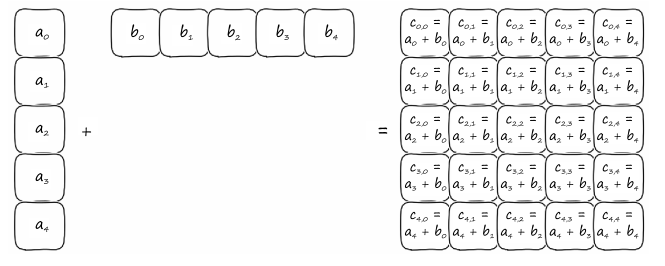

Конечно, все это останется чистой теорией, если не привести примеры кода:

In [8]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)

a = torch.ones(2, 1, 1)

print(f'shapes: x: {x.shape}, y: {y.shape}')

print(f'z: {z.shape}, a: {a.shape}')
print("x * y:", (x * y).shape,'\n', x * y)
print("y * z:", (x * z).shape, '\n', x * z)
print("y * z * a:", (x * z * a).shape, '\n', x * z * a)
print(a)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1]) 
 tensor([[1.],
        [1.],
        [1.]])
y * z: torch.Size([1, 3]) 
 tensor([[1., 1., 1.]])
y * z * a: torch.Size([2, 1, 3]) 
 tensor([[[1., 1., 1.]],

        [[1., 1., 1.]]])
tensor([[[1.]],

        [[1.]]])


***
## Вниз по градиенту

Мы будемоптимизировать функцию потерь относительно параметров с помощью
алгоритма градиентного спуска (gradient descent). В этом разделе мы разберемся,
как работает градиентный спуск с самого начала, что очень поможет нам в будущем. Как мы уже упоминали, существуют способы более эффективного решения
нашего примера, но эти подходы неприменимы к большинству задач глубокого
обучения. На самом деле идея градиентного спуска очень простая и хорошо подходит для больших нейросетевых моделей с миллионами параметров.

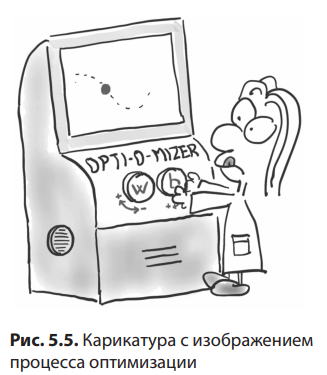

Начнем с мысленного представления, схематически изображенного на рис. 5.5.
Представьте себе, что вы стоите перед автоматомс двумя ручками с надписями w и b.
На экране можно увидеть значение функции потерь, и перед нами теперь поставлена
задача это значение минимизировать. Мы
не знаем, как ручки влияют на значение
функции потерь, и начинаем поворачивать
их туда-сюда, чтобы выяснить, поворот
в какую сторону каждой из ручек приводит
к уменьшению потерь. Мы решаем повернуть обе ручки в стороны, соответствующие уменьшению потерь. Допустим, мы
далеки от оптимального значения: вероятно, потери сначала начнут уменьшаться,
а затем темпы уменьшения замедлятся по
мере приближения к минимуму. В какойто момент мы замечаем, что потери опять
увеличиваются, поэтому решаемповернуть одну или обе ручки в другую сторону. Мы также выяснили, что при медленном
изменении функции потерь имеет смысл поворачивать ручки аккуратнее, чтобы
не пропустить момент, когда потери опять начнут расти. Через некоторое время
в конце концов процесс сходится к минимуму.

## Снижение потерь

Градиентный спуск не так уж сильно отличается от только что описанного
сценария. Его идея заключается в вычислении скорости изменения потерь по
каждому из параметров и изменении этих параметров в направлении снижения
потерь. Подобно тому как мы крутили ручки, можно оценить скорость изменения,
прибавив к w и b небольшие значения и посмотрев, насколько меняется функция
потерь в этой окрестности:

In [9]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) -
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

print(loss_rate_of_change_w)

tensor(4517.2974)


Этот значит, что в окрестности текущих значений w и b увеличение w на единицу
приводит к определенному изменению величины потерь. Если изменение отрицательное, необходимо увеличить w для минимизации потерь, а если положительное — уменьшить. На какую величину? Неплохой идеей будет корректировать w
пропорционально скорости изменения потерь, особенно если у функции потерь
есть несколько параметров: мы корректируем те из них, которые оказывают
существенное влияние на величину потерь. Имеет смысл также менять эти
параметры медленно, поскольку скорость изменений может резко отличаться
вдали от окрестности текущего значения w. Следовательно, обычно нужно
увеличивать скорость изменений лишь на небольшой коэффициент. У этого
масштабирующего коэффициента есть много названий; в машинном обучении
он называется **скоростью обучения (learning rate)**:

In [10]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w
print(w)

tensor(-44.1730)


Делаем то же самое с параметром b:

In [11]:
loss_rate_of_change_b = \
 (loss_fn(model(t_u, w, b + delta), t_c) -
  loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b
print(b)

tensor(46.)


Этот код отражает базовый шаг обновления параметров при градиентном спуске. 
Если мы будем повторять этот процесс (при условии достаточно маленькой скорости обучения), он постепенно сойдется к оптимальному значению параметров,
при котором функция потерь для конкретных данных минимальна. Скоро мы
продемонстрируем весь процесс последовательных приближений, но пока что
мы довольно грубо вычисляли темп изменений, и поэтому для начала нужно
модернизировать наш подход. Давайте посмотрим, как это сделать

***
## Выражаем аналитически

Вычисление скорости изменения путем последовательных оценок потерь модели, нужное для анализа поведения функции потерь в окрестностях w и b, плохо
масштабируется на модели с большим числом параметров. Кроме того, не всегда
ясно, насколько большой должна быть эта окрестность. В предыдущем разделе
мы выбрали `delta` равной `0.1`, но все зависит от формы графика потерь как
функции `w` и `b`. Если потери меняются слишком быстро по сравнению с `delta`,
будет сложно понять, в каком направлении потери снижаются быстрее всего.


А что, если сделать окрестность бесконечно малой, как на рис. 5.6? Именно это
и происходит при аналитическом выражении производной функции потерь
относительно какого-либо параметра. В моделях с двумя и более параметрами,
как наша, это означает вычисление частных производных функции потерь по
каждому из параметров и формирование из них вектора производных:градиента.

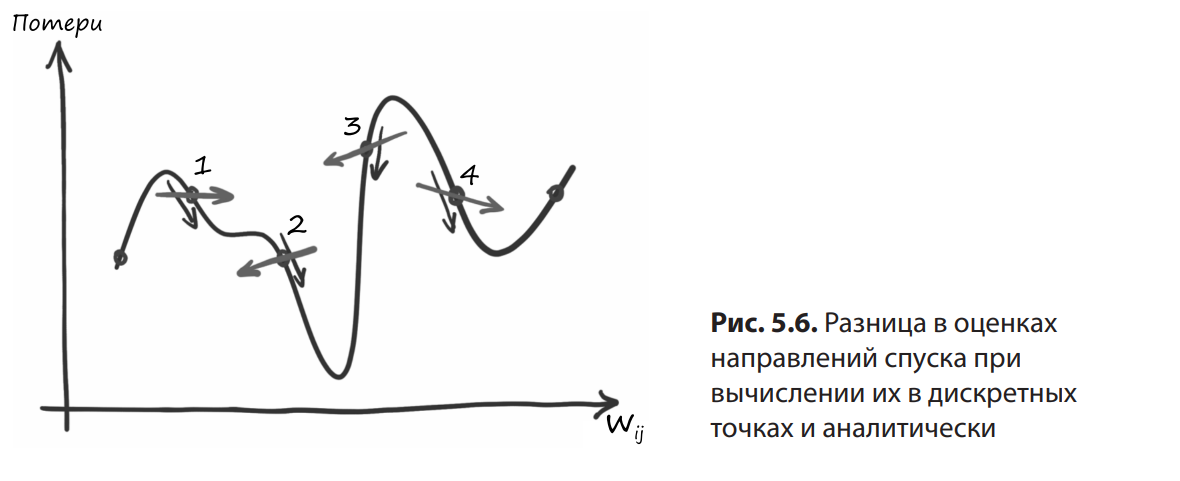

***
## Вычисление производных

Для вычисления производной функции потерь по параметру можно использовать цепное правило и вычислить производную функции потерь по ее входному
сигналу (то есть выходному сигналу модели), умножив на производную модели
по этому параметру:

Напомним, что наша модель — линейная функция, а функция потерь равна
сумме квадратов. Выведем выражения для производных. Напомним выражение
для функции потерь:

In [12]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Вспоминая, что d x^2 / d x = 2 x, получаем

In [13]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) # Делитель получается из производной математического ожидания
    return dsq_diffs

***
## Применение производных к модели

Поскольку наша модель выглядит следующим образом:

In [14]:
def model(t_u, w, b):
    return w * t_u + b

получаем следующие производные:

In [15]:
def dmodel_dw(t_u, w, b):
    return t_u # 1*t_u + 0

In [16]:
def dmodel_db(t_u, w, b):
    return 1.0

***
## Определение функции градиента

Собирая все воедино, получаем функцию, возвращающую градиент потерь относительно w и b:

In [17]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

Та же идея в математических обозначениях показана на `рис. 5.7.` Опять же мы
производим усреднение (то есть суммируем и делим на константу) по всем
точкам данных, получая одну скалярную величину для каждой частной производной функции потерь

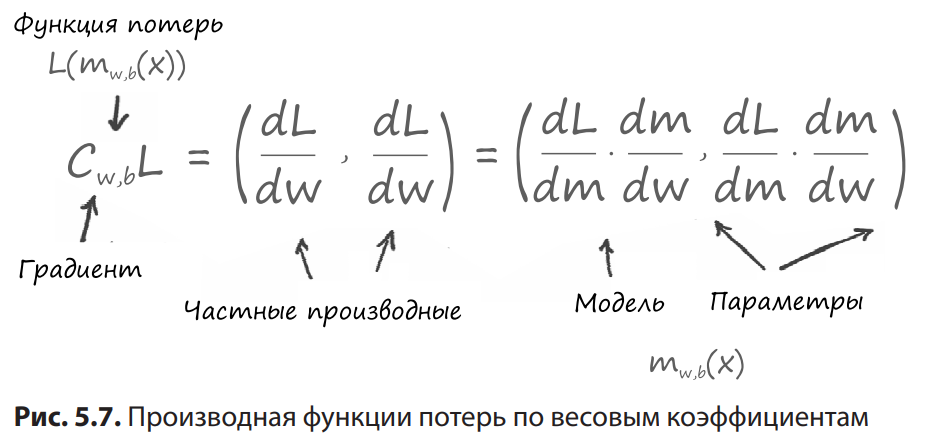

***
# Подгонка модели в цикле

Все готово к оптимизации параметров. Начиная с какого-либо предварительного
значения параметра, мы в цикле будем обновлять его в течение фиксированного
числа итераций либо до того момента, как w и b перестанут меняться. Существует
несколько критериев останова; пока что нас устраивает вариант с фиксированным числом итераций

## Цикл обучения
Раз уж мы с этим столкнулись, давайте введем еще несколько терминов. Отдельная итерация обучения, во время которой обновляются параметры для всех
обучающих примеров данных, называется эпохой


Полный цикл обучения выглядит следующим образом

In [18]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b) # Прямой проход
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b) # Обратный проход
        params = params - learning_rate * grad
        print('Epoch %d, Loss %f' % (epoch, float(loss))) # Объем выводимой в этой строке для целей журналирования информации может быть очень велик
    return params

Теперь запустим наш цикл обучения:

In [19]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 5802484.500000
Epoch 3, Loss 19408029696.000000
Epoch 4, Loss 64915905708032.000000
Epoch 5, Loss 217130525461053440.000000
Epoch 6, Loss 726257583152928129024.000000
Epoch 7, Loss 2429183416467662896627712.000000
Epoch 8, Loss 8125122549611731432050262016.000000
Epoch 9, Loss 27176882120842590626938030653440.000000
Epoch 10, Loss 90901105189019073810297959556841472.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epoch 38, Loss nan
Epoch 39, Loss nan
Epoch 40, Loss nan
Epoch 41, Loss

tensor([nan, nan])

## Переобучение

Ой, что произошло? Наш процесс обучения буквально разошелся, и потери
стали inf. Явный признак того, что обновления params слишком велики и их
значения начинают колебаться туда-сюда, когда очередное обновление приводит к слишком сильному увеличению, а следующее — корректирует еще больше, чем нужно. Процесс оптимизации неустойчив: он расходится, вместо того
чтобы сходиться к минимуму. Нам требуются все меньшие обновления params,
в отличие от показанного на рис. 5.8.

Как же ограничить порядок `learning_rate` * `grad`? Вроде бы это несложно. Можно
просто выбрать меньшее значение learning_rate, и действительно, скорость обучения является одной из тех величин, которые обычно меняют, когда обучение
идет не так гладко, как хотелось бы1
. Обычно скорости обучения меняют сразу на
порядки, так что можно попробовать коэффициент `1e-3` или `1e-4`, что приведет

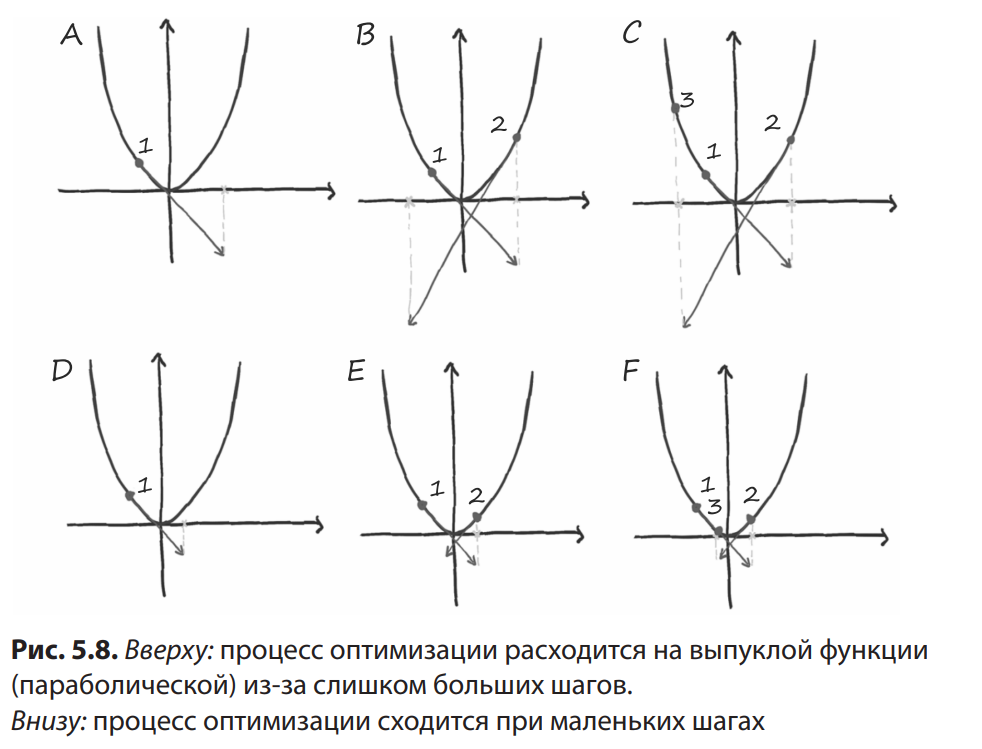

к снижению величины обновлений сразу на несколько порядков. Возьмем для
примера 1e-4 и посмотрим, что получится:

In [20]:
training_loop(
 n_epochs = 100,
 learning_rate = 1e-4,
 params = torch.tensor([1.0, 0.0]),
 t_u = t_u,
 t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 323.090515
Epoch 3, Loss 78.929634
Epoch 4, Loss 37.552845
Epoch 5, Loss 30.540283
Epoch 6, Loss 29.351154
Epoch 7, Loss 29.148884
Epoch 8, Loss 29.113848
Epoch 9, Loss 29.107145
Epoch 10, Loss 29.105247
Epoch 11, Loss 29.104168
Epoch 12, Loss 29.103222
Epoch 13, Loss 29.102295
Epoch 14, Loss 29.101379
Epoch 15, Loss 29.100466
Epoch 16, Loss 29.099548
Epoch 17, Loss 29.098631
Epoch 18, Loss 29.097717
Epoch 19, Loss 29.096796
Epoch 20, Loss 29.095881
Epoch 21, Loss 29.094959
Epoch 22, Loss 29.094049
Epoch 23, Loss 29.093134
Epoch 24, Loss 29.092216
Epoch 25, Loss 29.091301
Epoch 26, Loss 29.090385
Epoch 27, Loss 29.089464
Epoch 28, Loss 29.088551
Epoch 29, Loss 29.087635
Epoch 30, Loss 29.086714
Epoch 31, Loss 29.085804
Epoch 32, Loss 29.084888
Epoch 33, Loss 29.083967
Epoch 34, Loss 29.083057
Epoch 35, Loss 29.082142
Epoch 36, Loss 29.081221
Epoch 37, Loss 29.080309
Epoch 38, Loss 29.079390
Epoch 39, Loss 29.078474
Epoch 40, Loss 29.077562
Epoch 

tensor([ 0.2327, -0.0438])